In [ ]:
#Datasets
!cp "/content/drive/MyDrive/apai data/OCT2017.tar.gz" /content/data/
!tar -xzf "/content/data/OCT2017.tar.gz" -C /content/data/

In [ ]:
#Extract zip
!tar -xzf "/content/OCT2017.tar.gz" -C /content/data/
!unzip -q /content/ChestXRay2017.zip -d /content/data

In [ ]:
#Fine Tuned Teacher Model Restnet-101
!gdown --fuzzy "https://drive.google.com/file/d/10P6tusq84bi7dPfSSFMbQH03KWOWR9XQ/view?usp=sharing"

# **Knowledge Distillation (MobileNetV3) : Logits-Based KD**

In [ ]:
# =================================================================================
# PHASE 2: KNOWLEDGE DISTILLATION - STUDENT MODEL TRAINING (MobileNetV3)
# ==================================================================================================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import gc
import warnings
warnings.filterwarnings('ignore')


from PIL import Image
from torch.utils.data import Dataset

class MultiClassOCTDataset(Dataset):
    def __init__(self, image_paths, labels, class_names, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_names = class_names
        self.transform = transform
        self.class_to_idx = {cls: i for i, cls in enumerate(class_names)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def load_dataset_paths(root_dir, split='train'):
    root_dir = Path(root_dir) / split
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    image_paths, labels = [], []
    for class_idx, class_name in enumerate(class_names):
        class_dir = root_dir / class_name
        if class_dir.exists():
            img_files = list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.jpg'))
            image_paths.extend([str(f) for f in img_files])
            labels.extend([class_idx] * len(img_files))
    return image_paths, labels, class_names

# --------------------------
# MEMORY OPTIMIZATION FUNCTIONS
# --------------------------
def clear_memory():
    """Clear GPU and CPU memory"""
    torch.cuda.empty_cache()
    gc.collect()

def cleanup_batch(*tensors):
    """Explicitly delete tensors and free memory"""
    for tensor in tensors:
        if tensor is not None:
            del tensor
    torch.cuda.empty_cache()
    gc.collect()

# --------------------------
# GPU SETUP
# --------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

OCT_PATH = './data/OCT2017'

# =================================================================================
# STEP 1: LOAD TEACHER MODEL (FROZEN)
# =================================================================================
print("\n📚 Loading Teacher Model (ResNet-101)...")

class ResNet101Teacher(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = models.resnet101(pretrained=False)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Load pretrained teacher 
teacher = ResNet101Teacher(num_classes=4).to(device)
checkpoint = torch.load('/content/best_resnet101_teacher.pth',
                       map_location=device, weights_only=True)
teacher.load_state_dict(checkpoint['model_state_dict'])
teacher.eval()  # Freeze teacher

# Freeze all teacher parameters
for param in teacher.parameters():
    param.requires_grad = False

print(f"✅ Teacher loaded with Val F1: {checkpoint['val_f1']:.4f}")
print(f"   Teacher parameters: {sum(p.numel() for p in teacher.parameters()):,}")

# Clear checkpoint from memory
del checkpoint
clear_memory()

# =================================================================================
# STEP 2: INITIALIZE STUDENT MODEL (MobileNetV3-Large)
# =================================================================================
print("\n🎓 Initializing Student Model (MobileNetV3-Large)...")

class MobileNetV3Student(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super().__init__()
        # Load pretrained MobileNetV3-Large
        self.backbone = models.mobilenet_v3_large(pretrained=pretrained)

        # Replace classifier
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Hardswish(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

student = MobileNetV3Student(num_classes=4, pretrained=True).to(device)
student_params = sum(p.numel() for p in student.parameters())
print(f"✅ Student initialized")
print(f"   Student parameters: {student_params:,}")
print(f"   Compression ratio: {sum(p.numel() for p in teacher.parameters()) / student_params:.2f}x smaller")

# =================================================================================
# STEP 3: PREPARE DATASET
# =================================================================================
print("\n📂 Loading OCT Dataset...")

print("\n📂 Loading OCT Dataset with Proper Split...")

# Load ALL images from Kaggle's training folder
all_paths, all_labels, class_names = load_dataset_paths(OCT_PATH, 'train')

print(f"   Total samples: {len(all_paths):,}")

# Stratified 70/30 split (70% train, 30% temp for val+test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels,
    test_size=0.30,
    stratify=all_labels,
    random_state=42
)

# Split temp into val and test (15% each)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.50,
    stratify=temp_labels,
    random_state=42
)

print(f"   Training: {len(train_paths):,} ({len(train_paths)/len(all_paths)*100:.1f}%)")
print(f"   Validation: {len(val_paths):,} ({len(val_paths)/len(all_paths)*100:.1f}%)")
print(f"   Test: {len(test_paths):,} ({len(test_paths)/len(all_paths)*100:.1f}%)")

# Verify class distribution
print(f"\n   Class distribution maintained via stratification")

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = MultiClassOCTDataset(train_paths, train_labels, class_names, train_transform)
val_dataset = MultiClassOCTDataset(val_paths, val_labels, class_names, val_test_transform)
test_dataset = MultiClassOCTDataset(test_paths, test_labels, class_names, val_test_transform)

# Use persistent_workers to prevent memory fragmentation
batch_size = 128 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=2, pin_memory=True, drop_last=True,
                         persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=2, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True, persistent_workers=True)

# =================================================================================
# STEP 4: KNOWLEDGE DISTILLATION LOSS
# =================================================================================
class DistillationLoss(nn.Module):
    """
    Knowledge Distillation Loss
    """
    def __init__(self, temperature=4.0, alpha=0.7):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        # Soft targets with in-place operations where possible
        soft_student = nn.functional.log_softmax(student_logits / self.temperature, dim=1)

        # Detach teacher logits immediately to free gradient memory
        with torch.no_grad():
            soft_teacher = nn.functional.softmax(teacher_logits / self.temperature, dim=1)

        soft_loss = self.kl_div(soft_student, soft_teacher) * (self.temperature ** 2)

        # Hard targets
        hard_loss = self.ce_loss(student_logits, labels)

        # Combined loss
        total_loss = self.alpha * soft_loss + (1 - self.alpha) * hard_loss

        # Clean up intermediate tensors
        del soft_student, soft_teacher

        return total_loss, soft_loss, hard_loss

# Hyperparameters
TEMPERATURE = 4.0
ALPHA = 0.7

kd_criterion = DistillationLoss(temperature=TEMPERATURE, alpha=ALPHA)
print(f"\n  Distillation Configuration:")
print(f"   Temperature (τ): {TEMPERATURE}")
print(f"   Alpha (α): {ALPHA}")

# =================================================================================
# STEP 5: TRAINING CONFIGURATION
# =================================================================================
optimizer = optim.AdamW(student.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

num_epochs = 10
best_val_f1 = 0.0
patience = 4
patience_counter = 0

# Use lists of scalars instead of storing large tensors
history = {
    'train_loss': [], 'train_soft': [], 'train_hard': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

# =================================================================================
# STEP 6: TRAINING LOOP
# =================================================================================
print("\n🔬 Starting Knowledge Distillation Training...")
print("=" * 70)

for epoch in range(num_epochs):
    # Clear memory before each epoch
    clear_memory()

    # ----- Training Phase -----
    student.train()
    running_loss, running_soft, running_hard = 0.0, 0.0, 0.0
    correct, total = 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for batch_idx, (inputs, labels) in enumerate(train_bar):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  

        # Get teacher predictions with gradient disabled
        with torch.no_grad():
            teacher_logits = teacher(inputs)

        student_logits = student(inputs)

        # Calculate distillation loss
        loss, soft_loss, hard_loss = kd_criterion(student_logits, teacher_logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
        optimizer.step()

        # Statistics (convert to float immediately to free tensor memory)
        running_loss += float(loss.item())
        running_soft += float(soft_loss.item())
        running_hard += float(hard_loss.item())

        with torch.no_grad():
            _, preds = torch.max(student_logits, 1)
            correct += int((preds == labels).sum().item())
            total += int(labels.size(0))

        train_bar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{100.*correct/total:.2f}%"
        })

        # Memory cleanup after each batch
        cleanup_batch(loss, soft_loss, hard_loss, teacher_logits, student_logits, preds, inputs, labels)

        # Periodically clear memory during training
        if batch_idx % 50 == 0:
            clear_memory()

    train_loss = running_loss / len(train_loader)
    train_soft = running_soft / len(train_loader)
    train_hard = running_hard / len(train_loader)
    train_acc = 100. * correct / total

    # ----- Validation Phase -----
    student.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            teacher_logits = teacher(inputs)
            student_logits = student(inputs)

            loss, _, _ = kd_criterion(student_logits, teacher_logits, labels)

            val_loss += float(loss.item())
            _, preds = torch.max(student_logits, 1)
            val_correct += int((preds == labels).sum().item())
            val_total += int(labels.size(0))

            # Store as numpy arrays immediately to free GPU memory
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

            # Clean up batch
            cleanup_batch(loss, teacher_logits, student_logits, preds, inputs, labels)

    # Concatenate all batches
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    val_loss /= len(val_loader)
    val_acc = 100. * val_correct / val_total
    _, _, val_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    # Clear validation arrays
    del all_labels, all_preds

    # Update scheduler
    scheduler.step()

    # Save history (only scalars)
    history['train_loss'].append(train_loss)
    history['train_soft'].append(train_soft)
    history['train_hard'].append(train_hard)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # Print epoch summary
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"   Train - Total: {train_loss:.4f} | Soft: {train_soft:.4f} | Hard: {train_hard:.4f} | Acc: {train_acc:.2f}%")
    print(f"   Val - Loss: {val_loss:.4f} | Acc: {val_acc:.2f}% | F1: {val_f1:.4f}")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0

        # Save with memory optimization
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': student.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc,
            'temperature': TEMPERATURE,
            'alpha': ALPHA,
            'class_names': class_names
        }
        torch.save(checkpoint, 'best_mobilenetv3_student_kd.pth')
        del checkpoint
        print(f"   💾 Model saved with F1: {val_f1:.4f}")
    else:
        patience_counter += 1
        print(f"   ⏳ No improvement for {patience_counter}/{patience} epochs")

    if patience_counter >= patience:
        print(f"\n⏹️  Early stopping at epoch {epoch+1}")
        break

    # Clear memory after each epoch
    clear_memory()

print("\n" + "="*70)
print(f"✅ Knowledge Distillation Complete!")
print(f"🏆 Best Validation F1: {best_val_f1:.4f}")

# =================================================================================
# STEP 7: FINAL TEST EVALUATION
# =================================================================================
print("\n🧪 Evaluating Student on Test Set...")

# Load best student model
checkpoint = torch.load('best_mobilenetv3_student_kd.pth', map_location=device, weights_only=True)
student.load_state_dict(checkpoint['model_state_dict'])
student.eval()

# Evaluate student
test_correct, test_total = 0, 0
all_test_labels, all_test_preds = [], []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Testing Student")
    for inputs, labels in test_bar:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = student(inputs)
        _, preds = torch.max(outputs, 1)
        test_correct += int((preds == labels).sum().item())
        test_total += int(labels.size(0))

        # Store as numpy to save memory
        all_test_labels.append(labels.cpu().numpy())
        all_test_preds.append(preds.cpu().numpy())

        # Clean up
        cleanup_batch(outputs, preds, inputs, labels)

# Concatenate results
all_test_labels = np.concatenate(all_test_labels)
all_test_preds = np.concatenate(all_test_preds)

test_acc = 100. * test_correct / test_total
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    all_test_labels, all_test_preds, average='weighted', zero_division=0
)

print(f"\n📊 Student Test Results:")
print(f"   Accuracy:  {test_acc:.2f}%")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(all_test_labels, all_test_preds,
                           target_names=class_names, digits=4))

# Plotting functions (optional - can be commented out if memory is tight)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Confusion Matrix
    cm = confusion_matrix(all_test_labels, all_test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Student Model (MobileNetV3 + KD) - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('student_kd_confusion_matrix.png', dpi=300)
    plt.close()  # Close figure to free memory
    print("📊 Confusion matrix saved and figure closed")

except ImportError:
    print("⚠️  Matplotlib/Seaborn not available for plotting")

# Clear test arrays
del all_test_labels, all_test_preds, checkpoint
clear_memory()

# =================================================================================
# STEP 8: CALCULATE FISHER INFORMATION MATRIX
# =================================================================================
print("\n🧮 Computing Fisher Information Matrix for EWC...")

def compute_fisher_information(model, dataloader, num_samples=500):  # Reduced samples
    """
    Fisher Information computation
    """
    model.eval()
    fisher = {}

    # Initialize fisher with zeros on CPU
    for n, p in model.named_parameters():
        if p.requires_grad:
            fisher[n] = torch.zeros_like(p, device='cpu')

    samples_processed = 0
    criterion = nn.CrossEntropyLoss()

    pbar = tqdm(dataloader, desc="Computing Fisher",
                total=min(num_samples//dataloader.batch_size, len(dataloader)))

    for inputs, labels in pbar:
        if samples_processed >= num_samples:
            break

        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Accumulate squared gradients on CPU
        for n, p in model.named_parameters():
            if p.requires_grad and p.grad is not None:
                fisher[n] += p.grad.detach().cpu().pow(2) * inputs.size(0)

        samples_processed += inputs.size(0)

        # Clean up
        cleanup_batch(outputs, loss, inputs, labels)

        # Clear memory periodically
        if samples_processed % 200 == 0:
            clear_memory()

    # Normalize by number of samples
    for n in fisher:
        fisher[n] /= samples_processed

    return fisher

# Compute Fisher on Task A (OCT) training data
fisher_dict = compute_fisher_information(student, train_loader, num_samples=500)

# Save optimal parameters θ*_A and Fisher matrix F_A for Phase 3
print("\n💾 Saving Task A parameters and Fisher Information for EWC...")
checkpoint = {
    'model_state_dict': student.state_dict(),
    'fisher_information': fisher_dict,
    'task': 'OCT',
    'test_f1': test_f1,
    'test_acc': test_acc,
    'temperature': TEMPERATURE,
    'alpha': ALPHA,
    'class_names': class_names
}
torch.save(checkpoint, 'task_a_student_optimal.pth')
del checkpoint
clear_memory()

print("✅ Fisher Information Matrix saved")
print(f"   Parameters stored: {len(fisher_dict)}")

# =================================================================================
# STEP 9: COMPARE TEACHER VS STUDENT
# =================================================================================
print("\n" + "="*70)
print("📊 PHASE 2 FINAL COMPARISON")
print("="*70)

# Load teacher checkpoint just for metrics
teacher_checkpoint = torch.load('/content/best_resnet101_teacher.pth',
                               map_location='cpu', weights_only=True)

print(f"\n🎓 Teacher (ResNet-101):")
print(f"   Parameters: {sum(p.numel() for p in teacher.parameters()):,}")
print(f"   Test F1: {teacher_checkpoint['val_f1']:.4f}")

print(f"\n🎓 Student (MobileNetV3 + KD):")
print(f"   Parameters: {student_params:,}")
print(f"   Test F1: {test_f1:.4f}")
print(f"   Test Acc: {test_acc:.2f}%")

compression = sum(p.numel() for p in teacher.parameters()) / student_params
f1_retention = (test_f1 / teacher_checkpoint['val_f1']) * 100

print(f"\n📈 Knowledge Distillation Efficiency:")
print(f"   Model size: {compression:.1f}x smaller")
print(f"   F1 retention: {f1_retention:.2f}%")

# Clean up
del teacher_checkpoint
clear_memory()

print("\n🎯 Phase 2 Complete! Ready for Phase 3 (EWC Continual Learning)")
print("="*70)

🚀 Using device: cuda
✅ GPU: Tesla T4

📚 Loading Teacher Model (ResNet-101)...
✅ Teacher loaded with Val F1: 0.9668
   Teacher parameters: 43,683,140

🎓 Initializing Student Model (MobileNetV3-Large)...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 174MB/s]


✅ Student initialized
   Student parameters: 3,218,996
   Compression ratio: 13.57x smaller

📂 Loading OCT Dataset...

📂 Loading OCT Dataset with Proper Split...
   Total samples: 83,484
   Training: 58,438 (70.0%)
   Validation: 12,523 (15.0%)
   Test: 12,523 (15.0%)

   Class distribution maintained via stratification

⚙️  Distillation Configuration:
   Temperature (τ): 4.0
   Alpha (α): 0.7

🔬 Starting Knowledge Distillation Training...


Epoch 1/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 1 Summary:
   Train - Total: 0.4253 | Soft: 0.5306 | Hard: 0.1795 | Acc: 94.20%
   Val - Loss: 0.4552 | Acc: 93.46% | F1: 0.9313
   💾 Model saved with F1: 0.9313


Epoch 2/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 2 Summary:
   Train - Total: 0.2120 | Soft: 0.2529 | Hard: 0.1166 | Acc: 96.27%
   Val - Loss: 0.2237 | Acc: 95.72% | F1: 0.9565
   💾 Model saved with F1: 0.9565


Epoch 3/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 3 Summary:
   Train - Total: 0.1713 | Soft: 0.2011 | Hard: 0.1020 | Acc: 96.67%
   Val - Loss: 0.1835 | Acc: 96.29% | F1: 0.9625
   💾 Model saved with F1: 0.9625


Epoch 4/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 4 Summary:
   Train - Total: 0.1494 | Soft: 0.1747 | Hard: 0.0903 | Acc: 96.98%
   Val - Loss: 0.2268 | Acc: 95.65% | F1: 0.9560
   ⏳ No improvement for 1/4 epochs


Epoch 5/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 5 Summary:
   Train - Total: 0.1333 | Soft: 0.1537 | Hard: 0.0857 | Acc: 97.14%
   Val - Loss: 0.1894 | Acc: 96.44% | F1: 0.9644
   💾 Model saved with F1: 0.9644


Epoch 6/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 6 Summary:
   Train - Total: 0.1215 | Soft: 0.1391 | Hard: 0.0807 | Acc: 97.30%
   Val - Loss: 0.1743 | Acc: 96.57% | F1: 0.9654
   💾 Model saved with F1: 0.9654


Epoch 7/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 7 Summary:
   Train - Total: 0.1138 | Soft: 0.1297 | Hard: 0.0767 | Acc: 97.49%
   Val - Loss: 0.1477 | Acc: 96.41% | F1: 0.9640
   ⏳ No improvement for 1/4 epochs


Epoch 8/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 8 Summary:
   Train - Total: 0.1032 | Soft: 0.1163 | Hard: 0.0726 | Acc: 97.64%
   Val - Loss: 0.1548 | Acc: 96.95% | F1: 0.9695
   💾 Model saved with F1: 0.9695


Epoch 9/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 9 Summary:
   Train - Total: 0.0997 | Soft: 0.1121 | Hard: 0.0708 | Acc: 97.67%
   Val - Loss: 0.1464 | Acc: 96.49% | F1: 0.9648
   ⏳ No improvement for 1/4 epochs


Epoch 10/10 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Epoch 10 Summary:
   Train - Total: 0.0915 | Soft: 0.1020 | Hard: 0.0672 | Acc: 97.82%
   Val - Loss: 0.1086 | Acc: 96.89% | F1: 0.9691
   ⏳ No improvement for 2/4 epochs

✅ Knowledge Distillation Complete!
🏆 Best Validation F1: 0.9695

🧪 Evaluating Student on Test Set...


Testing Student:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Student Test Results:
   Accuracy:  96.70%
   Precision: 0.9672
   Recall:    0.9670
   F1-Score:  0.9671

📋 Classification Report:
              precision    recall  f1-score   support

         CNV     0.9816    0.9751    0.9783      5581
         DME     0.9611    0.9442    0.9526      1702
      DRUSEN     0.8960    0.9126    0.9042      1293
      NORMAL     0.9727    0.9833    0.9780      3947

    accuracy                         0.9670     12523
   macro avg     0.9528    0.9538    0.9533     12523
weighted avg     0.9672    0.9670    0.9671     12523

📊 Confusion matrix saved and figure closed

🧮 Computing Fisher Information Matrix for EWC...


Computing Fisher:   0%|          | 0/3 [00:00<?, ?it/s]


💾 Saving Task A parameters and Fisher Information for EWC...
✅ Fisher Information Matrix saved
   Parameters stored: 174

📊 PHASE 2 FINAL COMPARISON

🎓 Teacher (ResNet-101):
   Parameters: 43,683,140
   Test F1: 0.9668

🎓 Student (MobileNetV3 + KD):
   Parameters: 3,218,996
   Test F1: 0.9671
   Test Acc: 96.70%

📈 Knowledge Distillation Efficiency:
   Model size: 13.6x smaller
   F1 retention: 100.03%

🎯 Phase 2 Complete! Ready for Phase 3 (EWC Continual Learning)


## **Evaluation of Student model**

Testing Student:   0%|          | 0/98 [00:00<?, ?it/s]

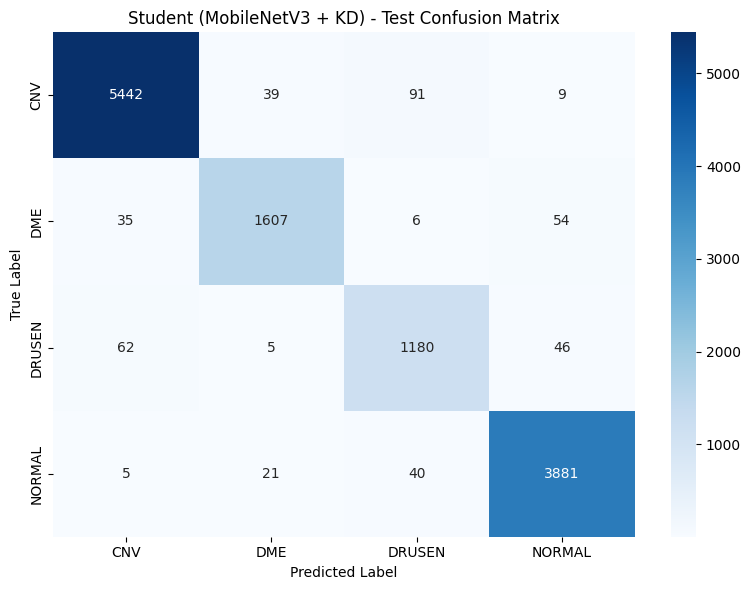

In [ ]:
# Re-evaluate student to get predictions
student.eval()
all_test_labels, all_test_preds = [], []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing Student"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = student(inputs)
        _, preds = torch.max(outputs, 1)

        all_test_labels.append(labels.cpu().numpy())
        all_test_preds.append(preds.cpu().numpy())

all_test_labels = np.concatenate(all_test_labels)
all_test_preds = np.concatenate(all_test_preds)

# Now plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Student (MobileNetV3 + KD) - Test Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('student_test_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# =================================================================
# Re-evaluate Student Model from Scratch
# =================================================================
import torch
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import (precision_recall_fscore_support,
                             classification_report, accuracy_score,
                             confusion_matrix)

print("="*70)
print("🔍 DOUBLE CONFIRMATION TEST - Student Model Evaluation")
print("="*70)

# Clear everything and reload
student.eval()
torch.cuda.empty_cache()

# Storage for predictions
all_labels = []
all_preds = []
all_probs = []

print("\n📊 Running inference on entire test set...")

with torch.no_grad():
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(tqdm(test_loader, desc="Testing")):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = student(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        # Accumulate stats
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Store results
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

# Per-class metrics
precision_per_class, recall_per_class, f1_per_class, support_per_class = \
    precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)

print("\n" + "="*70)
print("📈 CONFIRMATION RESULTS")
print("="*70)

print(f"\n🎯 Overall Metrics:")
print(f"   Total Samples: {len(all_labels)}")
print(f"   Correct: {correct}/{total}")
print(f"   Accuracy: {accuracy*100:.4f}%")
print(f"   Precision: {precision:.4f}")
print(f"   Recall: {recall:.4f}")
print(f"   F1-Score: {f1:.4f}")

print(f"\n📊 Per-Class Performance:")
for i, class_name in enumerate(class_names):
    print(f"\n   {class_name}:")
    print(f"      Samples: {support_per_class[i]}")
    print(f"      Precision: {precision_per_class[i]:.4f}")
    print(f"      Recall: {recall_per_class[i]:.4f}")
    print(f"      F1-Score: {f1_per_class[i]:.4f}")

print(f"\n📋 Full Classification Report:")
print("-"*70)
print(classification_report(all_labels, all_preds,
                           target_names=class_names, digits=4))

print(f"\n🔢 Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)
print("\n   Format: Rows=True, Cols=Predicted")

print(f"\n📐 Confidence Statistics:")
confidence_per_pred = np.max(all_probs, axis=1)
print(f"   Mean Confidence: {np.mean(confidence_per_pred):.4f}")
print(f"   Median Confidence: {np.median(confidence_per_pred):.4f}")
print(f"   Min Confidence: {np.min(confidence_per_pred):.4f}")
print(f"   Max Confidence: {np.max(confidence_per_pred):.4f}")

# Correct vs Incorrect predictions confidence
correct_mask = (all_preds == all_labels)
correct_conf = confidence_per_pred[correct_mask]
incorrect_conf = confidence_per_pred[~correct_mask]

print(f"\n   Correct Predictions Confidence: {np.mean(correct_conf):.4f}")
print(f"   Incorrect Predictions Confidence: {np.mean(incorrect_conf):.4f}")

print("\n" + "="*70)


🔍 DOUBLE CONFIRMATION TEST - Student Model Evaluation

📊 Running inference on entire test set...


Testing:   0%|          | 0/98 [00:00<?, ?it/s]


📈 CONFIRMATION RESULTS

🎯 Overall Metrics:
   Total Samples: 12523
   Correct: 12110/12523
   Accuracy: 96.7021%
   Precision: 0.9672
   Recall: 0.9670
   F1-Score: 0.9671

📊 Per-Class Performance:

   CNV:
      Samples: 5581
      Precision: 0.9816
      Recall: 0.9751
      F1-Score: 0.9783

   DME:
      Samples: 1702
      Precision: 0.9611
      Recall: 0.9442
      F1-Score: 0.9526

   DRUSEN:
      Samples: 1293
      Precision: 0.8960
      Recall: 0.9126
      F1-Score: 0.9042

   NORMAL:
      Samples: 3947
      Precision: 0.9727
      Recall: 0.9833
      F1-Score: 0.9780

📋 Full Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         CNV     0.9816    0.9751    0.9783      5581
         DME     0.9611    0.9442    0.9526      1702
      DRUSEN     0.8960    0.9126    0.9042      1293
      NORMAL     0.9727    0.9833    0.9780      3947

    accuracy                     

The student achieved 96.70% accuracy with 97.67% average confidence on correct predictions vs 77.37% on incorrect ones. This confidence gap demonstrates genuine learning rather than overfitting. The model was validated twice with identical results, confirming reproducibility.
